In [1]:
import operator
import psycopg2 as pg
import pandas as pd
import pandas.io.sql as pd_sql
import numpy as np

# visualization imports
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')

%matplotlib inline

# modelling imports
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, accuracy_score, roc_auc_score, roc_curve, precision_recall_curve, f1_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler


In [2]:
# Postgres info to connect

connection_args = {
    'host': 'localhost',
    'dbname': 'nfl_db',
    'port': 5432
}

connection = pg.connect(**connection_args) # Unpacks dictionary keys and values

In [3]:
# create Cowboys dataframe from selected columns

query = "SELECT play_id, game_date, yards_gained, play_type, posteam, \
        ydsnet, yardline_100, quarter_seconds_remaining, qtr, down, ydstogo \
        FROM nfl_plays \
        WHERE play_type IN ('pass','run') \
        AND posteam = 'DAL';"

df_cowboys = pd_sql.read_sql(query, connection)

In [4]:
df_cowboys.head()

,play_id,game_date,yards_gained,play_type,posteam,ydsnet,yardline_100,quarter_seconds_remaining,qtr,down,ydstogo
0,58,2009-09-13,-1.0,run,DAL,-1,64.0,892.0,1,1.0,10
1,231,2009-09-13,0.0,run,DAL,31,33.0,622.0,1,3.0,17
2,531,2009-09-13,19.0,run,DAL,19,48.0,267.0,1,1.0,10
3,557,2009-09-13,3.0,run,DAL,22,29.0,237.0,1,1.0,10
4,1366,2009-09-13,0.0,pass,DAL,15,75.0,265.0,2,2.0,8


In [5]:
# create binary for if the play is a pass

df_cowboys['passing'] = df_cowboys['play_type'].apply(lambda x: 1 if x == 'pass' else 0) 
df_cowboys.head()

,play_id,game_date,yards_gained,play_type,posteam,ydsnet,yardline_100,quarter_seconds_remaining,qtr,down,ydstogo,passing
0,58,2009-09-13,-1.0,run,DAL,-1,64.0,892.0,1,1.0,10,0
1,231,2009-09-13,0.0,run,DAL,31,33.0,622.0,1,3.0,17,0
2,531,2009-09-13,19.0,run,DAL,19,48.0,267.0,1,1.0,10,0
3,557,2009-09-13,3.0,run,DAL,22,29.0,237.0,1,1.0,10,0
4,1366,2009-09-13,0.0,pass,DAL,15,75.0,265.0,2,2.0,8,1


In [6]:
# create y for if the yards_gained were positive or not

df_cowboys['yards_g_l'] = df_cowboys['yards_gained'].apply(lambda x: 'gain' if x > 0 else 'loss')
df_cowboys.head()

,play_id,game_date,yards_gained,play_type,posteam,ydsnet,yardline_100,quarter_seconds_remaining,qtr,down,ydstogo,passing,yards_g_l
0,58,2009-09-13,-1.0,run,DAL,-1,64.0,892.0,1,1.0,10,0,loss
1,231,2009-09-13,0.0,run,DAL,31,33.0,622.0,1,3.0,17,0,loss
2,531,2009-09-13,19.0,run,DAL,19,48.0,267.0,1,1.0,10,0,gain
3,557,2009-09-13,3.0,run,DAL,22,29.0,237.0,1,1.0,10,0,gain
4,1366,2009-09-13,0.0,pass,DAL,15,75.0,265.0,2,2.0,8,1,loss


In [7]:
df_cowboys.dropna(inplace=True)
df_cowboys.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9891 entries, 0 to 9906
Data columns (total 13 columns):
play_id                      9891 non-null int64
game_date                    9891 non-null object
yards_gained                 9891 non-null float64
play_type                    9891 non-null object
posteam                      9891 non-null object
ydsnet                       9891 non-null int64
yardline_100                 9891 non-null float64
quarter_seconds_remaining    9891 non-null float64
qtr                          9891 non-null int64
down                         9891 non-null float64
ydstogo                      9891 non-null int64
passing                      9891 non-null int64
yards_g_l                    9891 non-null object
dtypes: float64(4), int64(5), object(4)
memory usage: 1.1+ MB


In [8]:
df_cowboys.columns

Index(['play_id', 'game_date', 'yards_gained', 'play_type', 'posteam',
       'ydsnet', 'yardline_100', 'quarter_seconds_remaining', 'qtr', 'down',
       'ydstogo', 'passing', 'yards_g_l'],
      dtype='object')

In [9]:
X_train, X_test, y_train, y_test = train_test_split(df_cowboys.iloc[:, 5:12], df_cowboys.iloc[:, 12], 
                                                    test_size = 0.2, random_state=33)

In [10]:
y_test_binary = y_test.apply(lambda x: 1 if x == 'gain' else 0)
y_test_binary.head(10)

3946    1
7248    1
2457    1
9109    0
2288    1
4032    0
2413    1
4785    0
6721    0
3642    0
Name: yards_g_l, dtype: int64

In [11]:
df_cowboys.groupby('yards_g_l').count()
# ratio of yards gain to yards loss is 69.4% to 30.6%
# model needs to have a score better than 69.4%

,play_id,game_date,yards_gained,play_type,posteam,ydsnet,yardline_100,quarter_seconds_remaining,qtr,down,ydstogo,passing
yards_g_l,,,,,,,,,,,,
gain,6862,6862,6862,6862,6862,6862,6862,6862,6862,6862,6862,6862
loss,3029,3029,3029,3029,3029,3029,3029,3029,3029,3029,3029,3029


In [12]:
train_df = X_train.copy()
train_df['yards_g_l'] = y_train

train_df.head()

,ydsnet,yardline_100,quarter_seconds_remaining,qtr,down,ydstogo,passing,yards_g_l
9260,78,60.0,350.0,2,1.0,10,0,gain
6183,21,59.0,94.0,4,4.0,4,1,loss
5936,4,43.0,659.0,4,2.0,6,0,loss
3798,8,84.0,542.0,4,2.0,8,0,gain
6520,38,32.0,724.0,2,2.0,4,0,gain


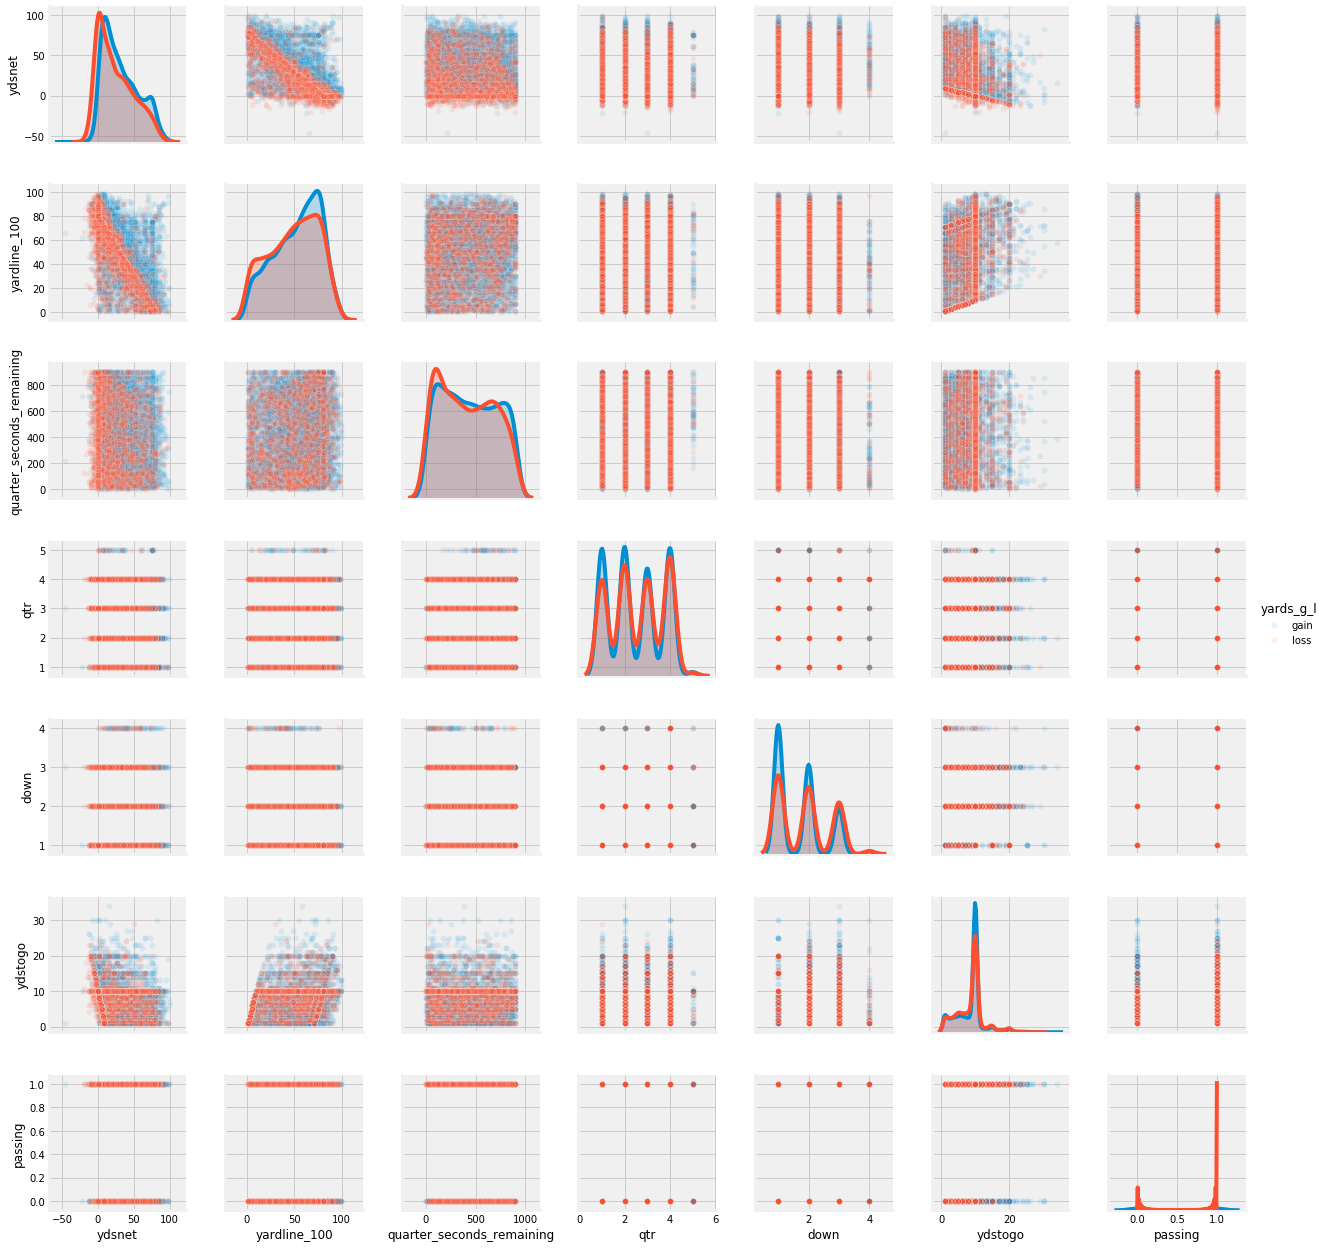

In [13]:
sns.pairplot(train_df, hue='yards_g_l', plot_kws={'alpha': 0.1});

In [14]:
std_scale = StandardScaler()

X_train_scaled = std_scale.fit_transform(X_train)
X_test_scaled = std_scale.fit_transform(X_test)

/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/lib/python3.7/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/lib/python3.7/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


## Logistic Regression

In [15]:
model_lr = LogisticRegression(random_state = 22)
model_lr.fit(X_train, y_train)

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=22, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [16]:
model_lr.score(X_test, y_test)

0.7296614451743305

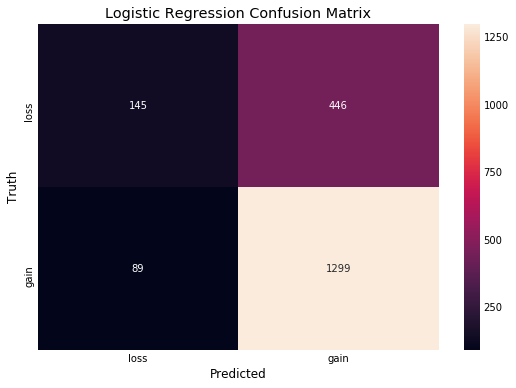

In [17]:
labels = ['loss','gain']

cm_lr = confusion_matrix(y_test, model_lr.predict(X_test), labels)

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)
sns.heatmap(cm_lr, annot=True, fmt='g').set_title('Logistic Regression Confusion Matrix')
ax.set_xticklabels(labels)
ax.set_yticklabels(labels)
plt.xlabel('Predicted')
plt.ylabel('Truth');


In [18]:
model_lr_scaled = LogisticRegression(random_state = 12)
model_lr_scaled.fit(X_train_scaled, y_train)

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=12, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [19]:
model_lr_scaled.score(X_test_scaled, y_test)

0.7316826680141486

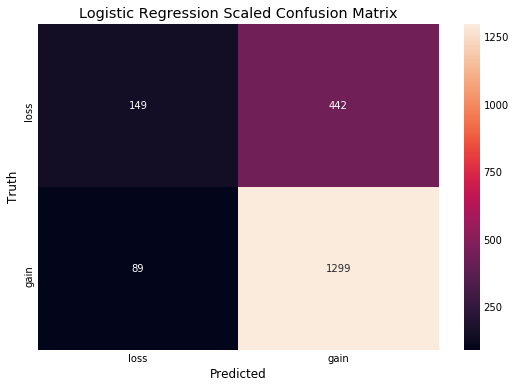

In [20]:
cm_lr_scaled = confusion_matrix(y_test, model_lr_scaled.predict(X_test_scaled), labels)

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)
sns.heatmap(cm_lr_scaled, annot=True, fmt='g').set_title('Logistic Regression Scaled Confusion Matrix')
ax.set_xticklabels(labels)
ax.set_yticklabels(labels)
plt.xlabel('Predicted')
plt.ylabel('Truth');

In [21]:
print(classification_report(y_test, model_lr_scaled.predict(X_test_scaled), labels))

              precision    recall  f1-score   support

        loss       0.63      0.25      0.36       591
        gain       0.75      0.94      0.83      1388

   micro avg       0.73      0.73      0.73      1979
   macro avg       0.69      0.59      0.59      1979
weighted avg       0.71      0.73      0.69      1979



ROC AUC score =  0.759051478225252


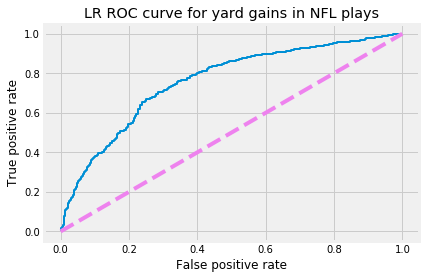

In [22]:
fpr, tpr, thresholds = roc_curve(y_test_binary, model_lr_scaled.predict_proba(X_test_scaled)[:,0])

plt.plot(fpr, tpr,lw=2)
plt.plot([0,1],[0,1],c='violet',ls='--')
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('LR ROC curve for yard gains in NFL plays');
print("ROC AUC score = ", roc_auc_score(y_test_binary, model_lr_scaled.predict_proba(X_test_scaled)[:,0]))

## KNN

In [23]:
from sklearn import neighbors
model_knn = neighbors.KNeighborsClassifier()

In [24]:
model_knn.fit(X_train_scaled, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform')

In [25]:
model_knn.score(X_test_scaled, y_test)

0.7124810510358767

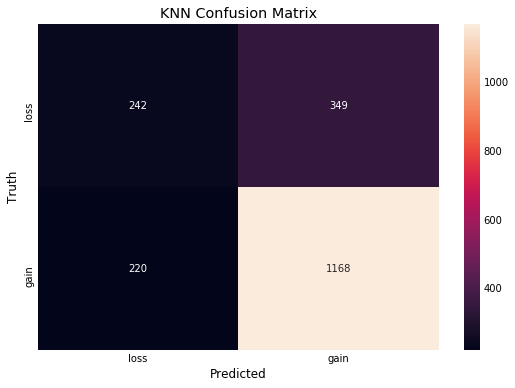

In [26]:
cm_knn = confusion_matrix(y_test, model_knn.predict(X_test_scaled), labels)

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)
sns.heatmap(cm_knn, annot=True, fmt='g').set_title('KNN Confusion Matrix')
ax.set_xticklabels(labels)
ax.set_yticklabels(labels)
plt.xlabel('Predicted')
plt.ylabel('Truth');

In [27]:
print(classification_report(y_test, model_knn.predict(X_test_scaled), labels))

              precision    recall  f1-score   support

        loss       0.52      0.41      0.46       591
        gain       0.77      0.84      0.80      1388

   micro avg       0.71      0.71      0.71      1979
   macro avg       0.65      0.63      0.63      1979
weighted avg       0.70      0.71      0.70      1979



ROC AUC score =  0.6931445262023532


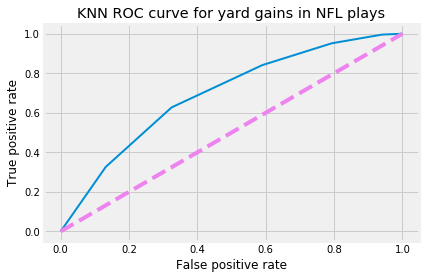

In [28]:
fpr, tpr, thresholds = roc_curve(y_test_binary, model_knn.predict_proba(X_test_scaled)[:,0])

plt.plot(fpr, tpr,lw=2)
plt.plot([0,1],[0,1],c='violet',ls='--')
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('KNN ROC curve for yard gains in NFL plays');
print("ROC AUC score = ", roc_auc_score(y_test_binary, model_knn.predict_proba(X_test_scaled)[:,0]))

## SVM

In [29]:
from sklearn.svm import SVC
model_svm = SVC(random_state = 30)

In [30]:
model_svm.fit(X_train_scaled, y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=30,
  shrinking=True, tol=0.001, verbose=False)

In [31]:
model_svm.score(X_test_scaled, y_test)

0.7614957049014653

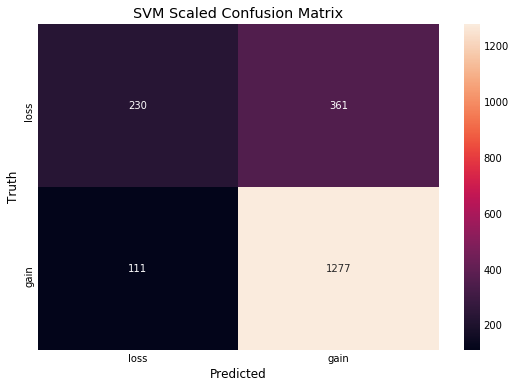

In [32]:
cm_svm = confusion_matrix(y_test, model_svm.predict(X_test_scaled), labels)

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)
sns.heatmap(cm_svm, annot=True, fmt='g').set_title('SVM Scaled Confusion Matrix')
ax.set_xticklabels(labels)
ax.set_yticklabels(labels)
plt.xlabel('Predicted')
plt.ylabel('Truth');

In [33]:
print(classification_report(y_test, model_svm.predict(X_test_scaled), labels))

              precision    recall  f1-score   support

        loss       0.67      0.39      0.49       591
        gain       0.78      0.92      0.84      1388

   micro avg       0.76      0.76      0.76      1979
   macro avg       0.73      0.65      0.67      1979
weighted avg       0.75      0.76      0.74      1979



## Decision Tree

In [34]:
from sklearn import tree

In [35]:
model_tree = tree.DecisionTreeClassifier(max_depth=9, random_state=44)

In [36]:
model_tree.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=9,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=44,
            splitter='best')

In [37]:
model_tree.score(X_train, y_train)

0.8326592517694641

In [38]:
model_tree.score(X_test, y_test)

0.7933299646286003

In [39]:
train_score = []
test_score = []

for i in range(1,21):
    model_test = tree.DecisionTreeClassifier(max_depth=i, random_state=44)
    model_test.fit(X_train, y_train)
    train_score.append(model_test.score(X_train, y_train))
    test_score.append(model_test.score(X_test, y_test))

In [40]:
train_score


[0.743680485338726,
 0.743680485338726,
 0.746840242669363,
 0.7592264914054601,
 0.775530839231547,
 0.7866531850353893,
 0.8004297269969667,
 0.8188827098078868,
 0.8326592517694641,
 0.8516177957532861,
 0.8696916076845298,
 0.8914307381193124,
 0.9111476238624874,
 0.9285894843276037,
 0.9471688574317493,
 0.962082912032356,
 0.9749747219413549,
 0.9828109201213346,
 0.9892568250758341,
 0.9935540950455005]

In [41]:
test_score

[0.7569479535118747,
 0.7569479535118747,
 0.7574532592218292,
 0.7635169277412834,
 0.7791814047498736,
 0.7817079332996463,
 0.7918140474987367,
 0.7918140474987367,
 0.7933299646286003,
 0.7892875189489641,
 0.7801920161697827,
 0.7786760990399192,
 0.7791814047498736,
 0.7680646791308742,
 0.764022233451238,
 0.7564426478019202,
 0.7539161192521475,
 0.7529055078322385,
 0.7584638706417383,
 0.7579585649317837]

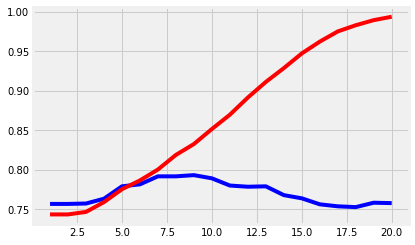

In [42]:
plt.plot(range(1,21), test_score, 'b', range(1,21), train_score, 'r')
plt.show()

# using max_depth of 9 gives best result on test set

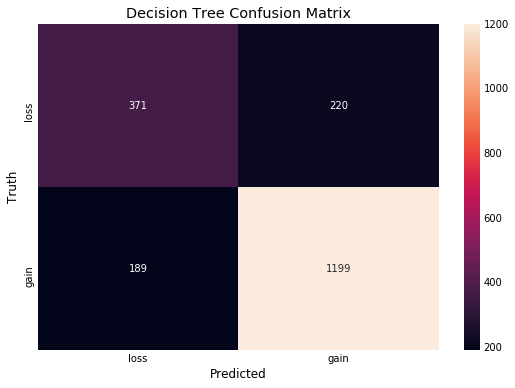

In [43]:
cm_tree = confusion_matrix(y_test, model_tree.predict(X_test), labels)

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)
sns.heatmap(cm_tree, annot=True, fmt='g').set_title('Decision Tree Confusion Matrix')
ax.set_xticklabels(labels)
ax.set_yticklabels(labels)
plt.xlabel('Predicted')
plt.ylabel('Truth');

In [44]:
print(classification_report(y_test, model_tree.predict(X_test), labels))

              precision    recall  f1-score   support

        loss       0.66      0.63      0.64       591
        gain       0.84      0.86      0.85      1388

   micro avg       0.79      0.79      0.79      1979
   macro avg       0.75      0.75      0.75      1979
weighted avg       0.79      0.79      0.79      1979



ROC AUC score =  0.8129470881668837


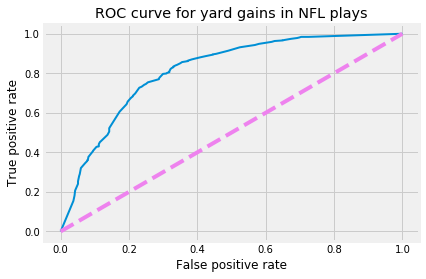

In [45]:
fpr, tpr, thresholds = roc_curve(y_test_binary, model_tree.predict_proba(X_test)[:,0])

plt.plot(fpr, tpr,lw=2)
plt.plot([0,1],[0,1],c='violet',ls='--')
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve for yard gains in NFL plays');
print("ROC AUC score = ", roc_auc_score(y_test_binary, model_tree.predict_proba(X_test)[:,0]))

## Naive Bayes - Gaussian

In [46]:
from sklearn import naive_bayes

In [47]:
model_NB_Gaus = naive_bayes.GaussianNB()

In [48]:
model_NB_Gaus.fit(X_train_scaled, y_train)

GaussianNB(priors=None, var_smoothing=1e-09)

In [49]:
model_NB_Gaus.score(X_test_scaled, y_test)

0.7210712481051036

## Extra Trees

In [50]:
from sklearn import ensemble

In [51]:
model_xtrees = ensemble.ExtraTreesClassifier(n_estimators=100, random_state=15)

In [52]:
model_xtrees.fit(X_train, y_train)

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=None, max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
           oob_score=False, random_state=15, verbose=0, warm_start=False)

In [53]:
model_xtrees.score(X_test, y_test)

0.7736230419403739

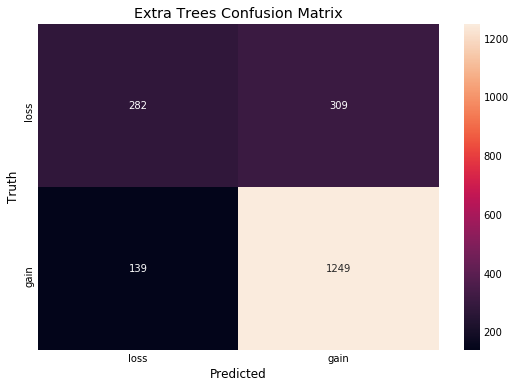

In [54]:
cm_xtrees = confusion_matrix(y_test, model_xtrees.predict(X_test), labels)

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)
sns.heatmap(cm_xtrees, annot=True, fmt='g').set_title('Extra Trees Confusion Matrix')
ax.set_xticklabels(labels)
ax.set_yticklabels(labels)
plt.xlabel('Predicted')
plt.ylabel('Truth');

In [55]:
print(classification_report(y_test, model_xtrees.predict(X_test), labels))

              precision    recall  f1-score   support

        loss       0.67      0.48      0.56       591
        gain       0.80      0.90      0.85      1388

   micro avg       0.77      0.77      0.77      1979
   macro avg       0.74      0.69      0.70      1979
weighted avg       0.76      0.77      0.76      1979



ROC AUC score =  0.797081096368681


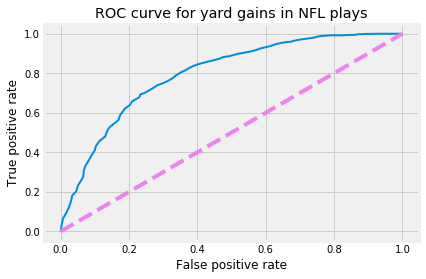

In [56]:
fpr, tpr, thresholds = roc_curve(y_test_binary, model_xtrees.predict_proba(X_test)[:,0])

plt.plot(fpr, tpr,lw=2)
plt.plot([0,1],[0,1],c='violet',ls='--')
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve for yard gains in NFL plays');
print("ROC AUC score = ", roc_auc_score(y_test_binary, model_xtrees.predict_proba(X_test)[:,0]))

## Random Forest

In [57]:
model_rf = ensemble.RandomForestClassifier(n_estimators=100, random_state=15)


In [58]:
model_rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=15, verbose=0, warm_start=False)

In [59]:
model_rf.score(X_test, y_test)

0.7973724103082365

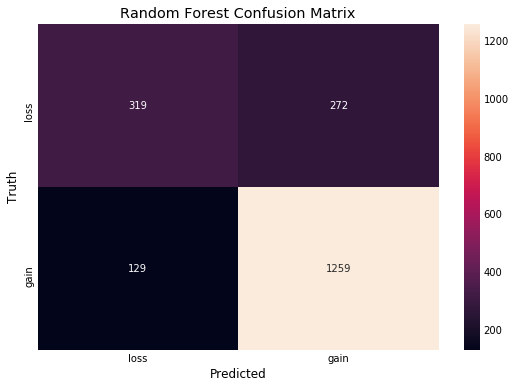

In [60]:
cm_rf = confusion_matrix(y_test, model_rf.predict(X_test), labels)

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)
sns.heatmap(cm_rf, annot=True, fmt='g').set_title('Random Forest Confusion Matrix')
ax.set_xticklabels(labels)
ax.set_yticklabels(labels)
plt.xlabel('Predicted')
plt.ylabel('Truth');

In [61]:
print(classification_report(y_test, model_rf.predict(X_test), labels))

              precision    recall  f1-score   support

        loss       0.71      0.54      0.61       591
        gain       0.82      0.91      0.86      1388

   micro avg       0.80      0.80      0.80      1979
   macro avg       0.77      0.72      0.74      1979
weighted avg       0.79      0.80      0.79      1979



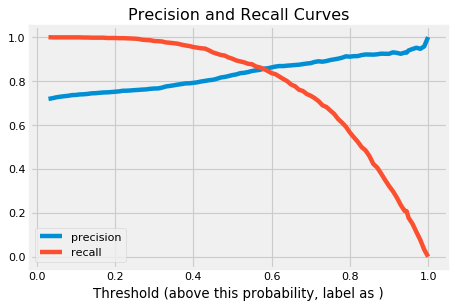

In [62]:
precision_curve, recall_curve, threshold_curve = precision_recall_curve(y_test_binary, model_rf.predict_proba(X_test)[:,0] )

plt.figure(dpi=80)
plt.plot(threshold_curve, precision_curve[1:],label='precision')
plt.plot(threshold_curve, recall_curve[1:], label='recall')
plt.legend(loc='lower left')
plt.xlabel('Threshold (above this probability, label as )');
plt.title('Precision and Recall Curves');


In [63]:
threshold = 0.44

predicted_proba = model_rf.predict_proba(X_test)
predicted = (predicted_proba [:,0] >= threshold).astype('int')

print(classification_report(y_test_binary, predicted))

              precision    recall  f1-score   support

           0       0.78      0.45      0.57       591
           1       0.80      0.95      0.87      1388

   micro avg       0.80      0.80      0.80      1979
   macro avg       0.79      0.70      0.72      1979
weighted avg       0.80      0.80      0.78      1979



In [64]:
threshold = np.arange(.40,.60,.01)

for i in threshold:
    predicted_proba = model_rf.predict_proba(X_test)
    predicted = (predicted_proba [:,0] >= i).astype('int')

    print(f1_score(y_test_binary, predicted))

0.8659726740403383
0.865661861074705
0.8667324777887462
0.8677004289013527
0.8661574227831286
0.8632564359745905
0.8633916554508748
0.8641138597085732
0.8643318599115948
0.8626241863651937
0.8624612202688728
0.8605135322692574
0.8614310645724258
0.8602451838879159
0.8590556730091614
0.8605803255484784
0.8570409982174689
0.856120257695061
0.855391272989542
0.8516503445774393


ROC AUC score =  0.8292281679564262


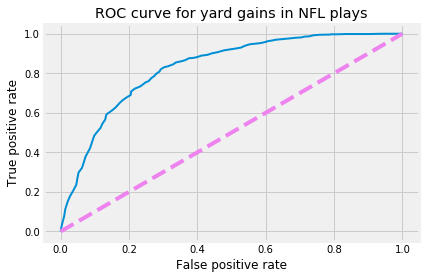

In [65]:
fpr, tpr, thresholds = roc_curve(y_test_binary, model_rf.predict_proba(X_test)[:,0])

plt.plot(fpr, tpr,lw=2)
plt.plot([0,1],[0,1],c='violet',ls='--')
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve for yard gains in NFL plays');
print("ROC AUC score = ", roc_auc_score(y_test_binary, model_rf.predict_proba(X_test)[:,0]))

In [66]:
## columns are ydsnet, yardline_100, quarter_seconds_remaining, qtr, down, ydstogo, passing

model_rf.predict([[78, 60.0, 350.0, 2, 1.0, 10, 0]])

array(['gain'], dtype=object)

#### Random Forest - Feature Importance - sklearn default

In [67]:
from sklearn.feature_selection import SelectFromModel

In [68]:
sel = SelectFromModel(ensemble.RandomForestClassifier(n_estimators = 100, random_state = 15))
sel.fit(X_train_scaled, y_train)
sel.get_support()

array([ True,  True,  True, False, False, False, False])

In [69]:
selected_feat= X_train.columns[(sel.get_support())]
print(selected_feat)

Index(['ydsnet', 'yardline_100', 'quarter_seconds_remaining'], dtype='object')


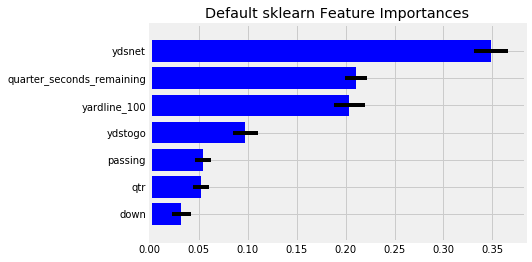

In [70]:
importances = model_rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in model_rf.estimators_],
             axis=0)
indices = np.argsort(importances)

# Plot the feature importances of the forest
plt.figure()
plt.title("Default sklearn Feature Importances")
plt.barh(range(X_train_scaled.shape[1]), importances[indices],
       color="b", xerr=std[indices], align="center")
# If you want to define your own labels,
# change indices to a list of labels on the following line.
plt.yticks(range(X_train_scaled.shape[1]), [X_train.columns[i] for i in indices])
plt.ylim([-1, X_train_scaled.shape[1]])
plt.show()

#### Random Forest - Feature Importance - rfpimp version

https://github.com/parrt/random-forest-importances

In [71]:
from rfpimp import *

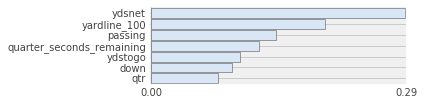

In [72]:
model_rf2 = ensemble.RandomForestClassifier(n_estimators=100, random_state=15)
model_rf2.fit(X_train, y_train)

imp = importances(model_rf2, X_train, y_train) # permutation
viz = plot_importances(imp, width=6)
viz.view()


Top 7 features in both cases are ydsnet, yardline_100, ydstogo, quarter_seconds_remaining, qtr, down, and passing

## Add model to Tableau

In [73]:
import tabpy_client

In [118]:
# Connect to TabPy server using the client library
tab_connection = tabpy_client.Client('http://localhost:9004/')

In [119]:
# Scoring function that will use Random Forest Classifier to classify new data
def GainNoGain(ydsnet, yardline_100, quarter_seconds_remaining, qtr, down, ydstogo, passing):
    X = np.column_stack([ydsnet, yardline_100, quarter_seconds_remaining, qtr, down, ydstogo, passing])
    return model_rf.predict(X).tolist()

In [120]:
# Testing function return
GainNoGain(20, 50.0, 500.0, 2, 1.0, 10, 1)

['gain']

In [121]:
# Publish the function to TabPy server so it can be used from Tableau
# Using the name NFLYardGains and a short description of what it does

tab_connection.deploy('NFLYardGains', GainNoGain,
                      'Returns if a play will be a yard gain or not based on Random Forest model trained using nflscrapR dataset',
                     override = True)

In [122]:
_arg1 = [1,2,3,4,6,7,8]
_arg2 = [1,2,3,4,6,7,8]
_arg3 = [1,2,3,4,6,7,8]
_arg4 = [1,2,3,4,6,7,8]
_arg5 = [1,2,3,4,6,7,8]
_arg6 = [1,2,3,4,6,7,8]
_arg7 = [1,2,3,4,6,7,8]

In [125]:
tab_connection.query('NFLYardGains', _arg1, _arg2, _arg3, _arg4, _arg5, _arg6, _arg7)

{'response': ['loss', 'loss', 'gain', 'loss', 'loss', 'loss', 'loss'],
 'version': 5,
 'model': 'NFLYardGains',
 'uuid': '95e79c23-1eac-41a2-b2d6-c944621618c9'}